---
title: TSEB in row crops
subject: Tutorial
subtitle: Notebook to evaluate the interception and absorption of irradiance in row crops
short_title: Row crops
authors:
  - name: Héctor Nieto
    affiliations:
      - Instituto de Ciencias Agrarias, ICA
      - CSIC
    orcid: 0000-0003-4250-6424
    email: hector.nieto@ica.csic.es
  - name: Benjamin Mary
    affiliations:
      - Insituto de Ciencias Agrarias
      - CSIC
    orcid: 0000-0001-7199-2885
license: CC-BY-SA-4.0
keywords: TSEB, radiation, Beer-Lambert law, albedo
---

# Summary
This interactive Jupyter Notebook has the objective of showing the implemenation of radiation transmission in row crops. It is based on [](https://doi.org/10.1007/s00271-019-00621-x)

We will make use of simulation models, particularly radiative transfer models at both leaf and canopy levels.

# Instructions
Read carefully all the text and follow the instructions.

Once each section is read, run the jupyter code cell underneath (marked as `In []`) by clicking the icon `Run`, or pressing the keys SHIFT+ENTER of your keyboard. A graphical interface will then display, which allows you to interact with and perform the assigned tasks.

To start, please run the following cell to import all the packages required for this notebook. Once you run the cell below, an acknowledgement message, stating all libraries were correctly imported, should be printed on screen.

In [1]:
%matplotlib inline
from pathlib import Path
from ipywidgets import interact, interactive, fixed, widgets
from IPython.display import display
from functions import radiation_and_available_energy as fn
import numpy as np

scikit-learn-intelex not available, skipping the use af Intel acceleration.
Try to consider installing Intel acceleration via `pip install scikit-learn-intelex`
Thanks! libraries imported
You can now continue with the following tasks


# Shortwave radiation in row crops
So far, all simulations and processes have assumed a horizontally homogeneous canopy or crop, or at least dense enough to approximate a homogeneous crop. However, what happens when one is working with row crops or isolated canopies, such as in vineyards or orchards?

The hard fact is that everything is much more complex as on the one hand the canopy is usually clumped around a stem and branches, leaving some parts of the ground fully exposed. On the other hand, in row crops, the dimension of the canopy/trellis system and the orientation of the rows also affect how light is intercepted and transmitted between the crop and the ground.

In order to evaluate this situation, we need to consider additional parameters of crop structure:

* The canopy height ($h_c$), since higher canopies will cast longer shadows in the interrow.
* The fraction of canopy occupied by the ground ($f_c$), or the ratio between the canopy/trellis width ($w_c$) and the row spacing (L).
* The azimuth row orientation, with respect to the north. 0º will indicate that the rows are oriented S-N, negative values indicate that the rows go from NW to SE, and positive values from NE to SW, with -90º and/or 90º showing rows oriented E-W.

:::{figure} ./input/figures/row_crop_shadowing.webp
:alt: Row crop shadowing model
:name: row-crop-model
Canopy model for estimating the clumping index in row crops, F is the leaf area index, L is the distance between rows, hc is the canopy height, hb is the height of the canopy above ground, and wc is the canopy width
:::

The approach builds upon the concept of the clumping index, defined as a conversion factor that modifies the leaf area index of a real canopy (F) in a fictitious homogeneous canopy with $LAI_{eff} = \Omega\left(\theta, \psi\right) F$, such as its gap fraction ($G\left(\theta, \psi\right)$) is the same as the gap fraction of the real-world canopy:

:::{math}
:label:eq-gapfraction
\Omega\left(\theta,\psi\right) F \kappa_b\left(\theta\right)= -\log\left[G\left(\theta,\psi\right)\right]
:::
with $\kappa_b\left(\theta\right)$ is the beam extinction cofficient computed for a homogenous canopy (e.g. using [](https://doi.org/10.1007/978-1-4612-1626-1).

The real canopy gap fraction is estimated on this simplied model as the sunlit part of the bare soil that is not shaded by the canopy ($1 - f_{sc}$) plus the gaps caused by the solar beam passing through the crop canopy (ignoring mutual shadowing between rows:

:::{math}
G(\theta ,\psi)={f_{sc}}(\theta ,\psi )\exp [ - {\kappa _{{\text{b}}}}(\theta )F]+[1 - {f_{{\text{sc}}}}(\theta ,\phi )].
:::

and $f_{sc}$ is computed from (#row-crop-model) using trigonometry:

:::{math}
{f_{{\text{sc}}}}(\theta ,\phi )=\frac{{{w_{\text{c}}}+({h_{\text{c}}} - {h_{\text{b}}})\tan \theta |\sin \phi |}}{L}
:::

In the following interactive plot, we have added these parameters to see their effect on net radiation. In addition, to ease the comparison with previous plot, we have included a second graph that shows the fraction of absorbed radiation for both a horizontally homogeneous crop and a row crop.

In [2]:
w_sn = interactive(fn.plot_net_solar_radiation,
                   lai=fn.w_lai, leaf_angle=fn.w_leaf_angle, h_c=fn.w_hc, f_c=fn.w_fc,
                   row_distance=fn.w_interrow, row_direction=fn.w_psi, sdn_day=fn.w_sdn, skyl=fn.w_skyl, 
                   fvis=fixed(0.55), lat=fn.w_lat, cab=fn.w_cab, cw=fn.w_cw, soil_type=fn.w_soil)
display(w_sn)

interactive(children=(FloatSlider(value=2.0, continuous_update=False, description='LAI (m²/m²)', max=4.0, tool…

* The sun rises from the eastern side, at noon reaches its zenith towards the north (or south depending on whether we are north or south of the equator), and sunset is from the western side. Taking into account these facts, observe the effect of changing the row orientation from E-W to S-N. There should be a drop in canopy net radiation when the sun is parallel to the rows, as in this case there should be lower radiation interception by the canopy.

* Observe that with larger canopy fractions ($f_c$, or wider canopies relative to the row spacing), the crop behaves similarly to the homogeneous crops from the previous simulation.

* There is an interaction effect between canopy height and row separation (`L`). Narrower rows in lower crops display a similar effect as that of taller crops in wider rows.

* Finally, as we have seen in previous interactive plots, these effects are minimized at larger proportion of diffuse radiation.

:::{seealso}
:class:dropdown
Check the code in the [pyTSEB GitHub repository](https://github.com/hectornieto/pyTSEB/blob/9d1f02ec2968bb323c07528ba44144c3733f3737/pyTSEB/clumping_index.py#L124).
:::

# Implementation with actual data in [pyTSEB](https://github.com/hectornieto/pyTSEB)
We will work some of the sites of GRAPEX. There are a few sites with measurements of below canopy radiation that could be used to evaluate the model. In this case we can work with the sites in Sierra Loma and Barrelli, with different row orientations and canopy sctructure.

:::{table} Site characteristics
:name: site-description
Site | Latitude | Longitude | Elevation (m) | Row direction (deg.) | Row spacing (m) | Min. height (m) | Max. height (m) | Min. width (m) | Max. width (m) | TA height (m) | WS height (m)
:-- | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --:
Barrelli_007 | 38.753 | -122.98 | 113 | 135 | 3.35 | 1.25 | 2.3 | 0.5 | 1.8 | 4 | 4
Barrelli_012 | 38.751369 | -122.974658 | 112 | 45 | 3.35 | 1.25 | 2.3 | 0.5 | 1.8 | 4.4 | 4.4
Sierra Loma-north | 38.289338 | -121.117764 | 38 | 90 | 3.35 | 0.5 | 1.42 | 0.8 | 2.6 | 5 | 5
Sierra Loma-south | 38.280488 | -121.117597 | 37 | 90 | 3.35 | 0.5 | 1.42 | 0.8 | 2 | 5 | 5
:::

The input we will use can be found in [](./input/meteo/) for the micrometeorological data and in [](./input/radiation) for the below canopy radiation measurements.

On the other hand, LAI was obtained from Earth Observation data {cite:p}`https://doi.org/10.1007/s00271-022-00798-8`

## Select a site

In [4]:
w_site = widgets.Dropdown(
    options=[('Sierra Loma N', "slmN"), ('Sierra Loma S', "slmS"), ('Barrelli_007', "bar007"), ('Barrelli_012', "bar012")],
    value="slmN",
    description='Site:',
)
display(w_site)

Dropdown(description='Site:', options=(('Sierra Loma N', 'slmN'), ('Sierra Loma S', 'slmS'), ('Barrelli_007', …

## Read the radiation and LAI timeseries

In [5]:
# Import Python libraries
from pathlib import Path
import pandas as pd

# Set the LAI and readiation folders
input_dir = Path().absolute() / "input"
lai_dir = input_dir / "canopy"
rad_dir = input_dir / "radiation"
# Set the input files based on the chosen site
lai_filename = lai_dir / f"FLX_US-{w_site.value}_FLUXNET2015_AUXCANOPY_DD.csv"
rad_filename = rad_dir / f"FLX_US-{w_site.value}_FLUXNET2015_AUXRADIATION_HH.csv"
print(f"LAI file path is {lai_filename}")
print(f"Radiation file path is {rad_filename}")

# Read the LAI and radiation tables
lai = pd.read_csv(lai_filename, sep=";", na_values=-9999)
rad = pd.read_csv(rad_filename, sep=";", na_values=-9999)

# Merge both tables by date
rad["TIMESTAMP"] = pd.to_datetime(rad["TIMESTAMP"], format="%Y%m%d%H%M")
lai["DATE"] = pd.to_datetime(lai["TIMESTAMP"], format="%Y%m%d").dt.date
lai = lai.drop(labels=["TIMESTAMP"], axis=1)
rad["DATE"] = rad["TIMESTAMP"].dt.date
rad = rad.merge(lai, on="DATE")

# We discard all cases at night (SW_IN <=0)
rad = rad[rad["SW_IN"] > 0]


LAI file path is C:\Users\06325897T\Nextcloud\1_Projects\ILINK24\Workshop_3SEB_UCDavis\py3SEB-workshop\input\canopy\FLX_US-slmN_FLUXNET2015_AUXCANOPY_DD.csv
Radiation file path is C:\Users\06325897T\Nextcloud\1_Projects\ILINK24\Workshop_3SEB_UCDavis\py3SEB-workshop\input\radiation\FLX_US-slmN_FLUXNET2015_AUXRADIATION_HH.csv


### Plot the input variables

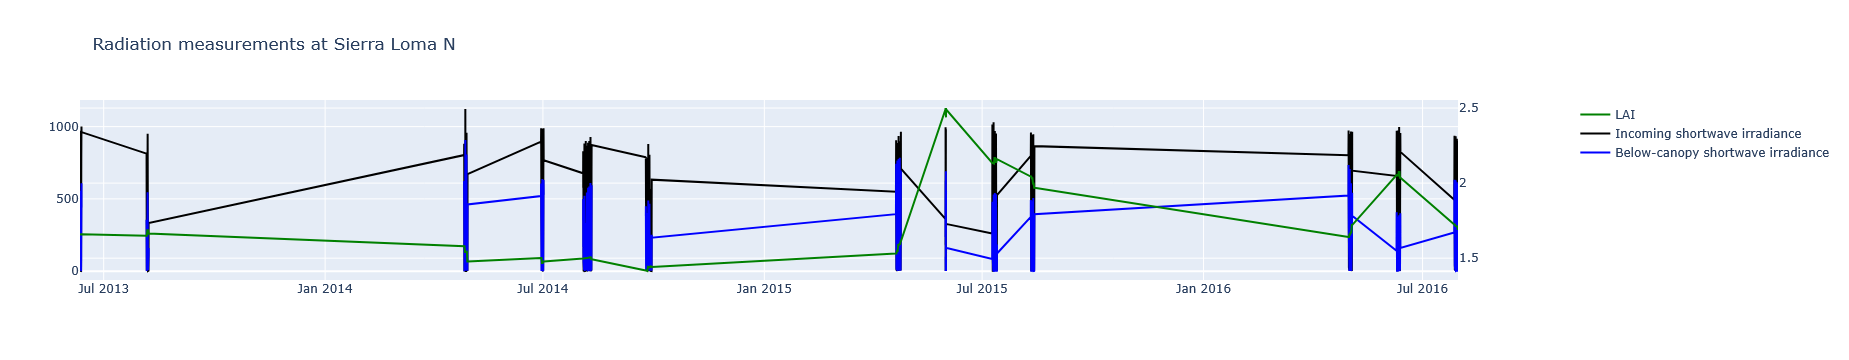

In [6]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=rad["TIMESTAMP"], y=rad["LAI"], 
                         name="LAI", 
                         mode="lines", line={"color":"green"}),
              secondary_y=True)

fig.add_trace(go.Scatter(x=rad["TIMESTAMP"], y=rad["SW_IN"], 
                         name="Incoming shortwave irradiance",
                         mode="lines",line={"color":"black"})
             )

fig.add_trace(go.Scatter(x=rad["TIMESTAMP"], y=rad["SW_BELOW"],
                         name="Below-canopy shortwave irradiance", 
                         mode="lines", line={"color":"blue"})
             )

fig.update_layout(title_text=f"Radiation measurements at {w_site.label}",
                 hovermode="x")

## Get the canopy a priori structural properties

In [7]:
import yaml
yaml_file = input_dir / "site_description.yaml"
site_dict = yaml.safe_load(yaml_file.read_text())
lat = float(site_dict["lat"][w_site.value])
lon = float(site_dict["lon"][w_site.value])
elev = float(site_dict["elev"][w_site.value])
row_direction = float(site_dict["row_direction"][w_site.value])
interrow = float(site_dict["interrow"][w_site.value])
hc_min = float(site_dict["hc_min"][w_site.value])
hc_max = float(site_dict["hc_max"][w_site.value])
wc_min = float(site_dict["wc_min"][w_site.value])
wc_max = float(site_dict["wc_max"][w_site.value])
zh = float(site_dict["zh"][w_site.value])
zm = float(site_dict["zm"][w_site.value])

print(f"{w_site.label} has the following site characteristics:\n"
      f"\t Latitude: {lat} deg. \n"
      f"\t Longitude: {lon} deg. \n"
      f"\t Elevation: {elev} m \n"
      f"\t Row direction: {row_direction} deg. \n"
      f"\t Row spacing: {interrow} m \n"
      f"\t Min. canopy height: {hc_min} m \n"
      f"\t Max. canopy height: {hc_max} m \n"
      f"\t Min. canopy width: {wc_min} m \n"
      f"\t Max. canopy width: {wc_max} m \n"
)

Sierra Loma N has the following site characteristics:
	 Latitude: 38.289338 deg. 
	 Longitude: -121.117764 deg. 
	 Elevation: 38.0 m 
	 Row direction: 90.0 deg. 
	 Row spacing: 3.35 m 
	 Min. canopy height: 1.42 m 
	 Max. canopy height: 2.25 m 
	 Min. canopy width: 0.5 m 
	 Max. canopy width: 2.6 m 



## Estimate the structural variables based on Earth Observation LAI timeseries
we will estimate timeseries of canopy structural variables based on LAI and empirical observations of trellis development. These relationships were obtained for Sierra Loma {cite:p}`https://doi.org/10.1007/s00271-018-0611-y` so they might be less robust in other sites

:::{figure} ./input/figures/vineyard_structural_functions.png
:alt: Empirical structural functions
:name: structural-functions
Empirical models relating canopy height , canopy width and the bottom of the canopy with the fused STARFM LAI. Solid dots represent in situ measured values
:::
These empirical equations are coded in Python as:

In [8]:
import numpy as np

################################################################################
# Empirical equations to generate canopy structural parameters from LAI
################################################################################
def lai_2_hc(lai, hc_min):
    slope = 0.42
    hc = hc_min + slope * lai
    return hc


def lai_2_hbratio(lai, hc_min):
    hb_ratio_mean = 0.4848388065
    hb_ratio = np.zeros(lai.shape)

    hb_ratio[lai < hc_min] = 1. + ((hb_ratio_mean - 1.) / hc_min) * lai[
        lai < hc_min]
    hb_ratio[lai >= hc_min] = hb_ratio_mean

    return hb_ratio


def lai_2_width(lai, wc_min, wc_max):
    beta = 6.96560056
    offset = 1.70825736

    width = wc_min + (wc_max - wc_min) / (1.0 + np.exp(-beta * (lai - offset)))

    return width


def lai_2_fcover(lai, fc_min, fc_max):
    beta = 7.0
    offset = 1.70

    fcover = fc_min + (fc_max - fc_min) / (1.0 + np.exp(-beta * (lai - offset)))

    return fcover


def lai_2_canopy(lai, hc_min, fc_min, fc_max):
    hc = lai_2_hc(lai, hc_min)
    hb_ratio = lai_2_hbratio(lai, hc_min)
    fcover = lai_2_fcover(lai, fc_min, fc_max)

    return hc, hb_ratio, fcover

From these empirical functions together with the site description properties described in [](#site-description) we can caluculate the time series of canopy structural variables needed to compute the shadowing as shown in [](#row-crop-model)

:::{note}
:class: dropdown
These equations are site specific and most likely not applicable to other sites and crops. For operational purposes, such as using Earth Observation/satellite data a trade-off must be made between accuracy and applicability.
:::

In [9]:
# Compute the expected minimum and maximum canopy cover based on mininum and maximum canopy width
fc_min = wc_min / interrow
fc_max = wc_max / interrow
h_c, hb_ratio, f_c = lai_2_canopy(rad["LAI"].values,
                                  hc_min,
                                  fc_min,
                                  fc_max)

# Ensure that both canopy height and cover are within the limits
h_c = np.clip(h_c, hc_min, hc_max)
f_c = np.clip(f_c, 0, 1)

## We can define the spectral properties of our leaves and soil

In [10]:
style = {'description_width': 'initial'}
w_rho_leaf_vis = widgets.BoundedFloatText(min=0, max=1, value=0.05, description='Leaf PAR reflectance', step=0.01, style=style)
w_rho_leaf_nir = widgets.BoundedFloatText(min=0, max=1, value=0.35, description='Leaf NIR reflectance', step=0.01, style=style)
w_tau_leaf_vis = widgets.BoundedFloatText(min=0, max=1, value=0.05, description='Leaf PAR transmittance', step=0.01, style=style)
w_tau_leaf_nir = widgets.BoundedFloatText(min=0, max=1, value=0.35, description='Leaf NIR transmittance', step=0.01, style=style)
w_rho_soil_vis = widgets.BoundedFloatText(min=0, max=1, value=0.15, description='Soil PAR reflectance', step=0.01, style=style)
w_rho_soil_nir = widgets.BoundedFloatText(min=0, max=1, value=0.25, description='Soil NIR reflectance', step=0.01, style=style)
display(w_rho_leaf_vis, w_rho_leaf_nir, w_tau_leaf_vis, w_tau_leaf_nir, w_rho_soil_vis, w_rho_soil_nir)

BoundedFloatText(value=0.05, description='Leaf PAR reflectance', max=1.0, step=0.01, style=DescriptionStyle(de…

BoundedFloatText(value=0.35, description='Leaf NIR reflectance', max=1.0, step=0.01, style=DescriptionStyle(de…

BoundedFloatText(value=0.05, description='Leaf PAR transmittance', max=1.0, step=0.01, style=DescriptionStyle(…

BoundedFloatText(value=0.35, description='Leaf NIR transmittance', max=1.0, step=0.01, style=DescriptionStyle(…

BoundedFloatText(value=0.15, description='Soil PAR reflectance', max=1.0, step=0.01, style=DescriptionStyle(de…

BoundedFloatText(value=0.25, description='Soil NIR reflectance', max=1.0, step=0.01, style=DescriptionStyle(de…

## Now parse the spectral propoerties and also compute illumination angles

In [11]:
from pyTSEB import TSEB

# We can get the leaf and soil spectral from the values above, or hard code the corresponding values
rho_leaf_vis = w_rho_leaf_vis.value
rho_leaf_nir = w_rho_leaf_nir.value
tau_leaf_vis = w_tau_leaf_vis.value
tau_leaf_nir = w_tau_leaf_nir.value
rho_soil_vis = w_rho_soil_vis.value
rho_soil_nir = w_rho_soil_nir.value

# We also need to compute the solar angles
# The time zone is PST, which corresponds to -120 deg, time longitude
stdlon = -120
# Call calc_sun_angles based on site coordinates and timestamp
sza, saa = TSEB.met.calc_sun_angles(
    np.full_like(rad['LAI'].values, lat),
    np.full_like(rad["LAI"].values, lon),
    np.full_like(rad["LAI"].values, stdlon),
    rad['TIMESTAMP'].dt.dayofyear.values,
    rad['TIMESTAMP'].dt.hour.values + rad['TIMESTAMP'].dt.minute.values / 60.)


## We compute the clumping index and effective LAI for row crops

In [12]:
# canopy width
w_c = f_c * interrow
# Canopy width to height ratio
w_c_ratio = w_c / (h_c - hb_ratio * h_c)
# Local LAI
F = rad["LAI"].values / f_c

# Compute the relative sun-row azimuth angle
psi = row_direction - saa
# Compute the clumping index for row crops
# Calculate the zenith angle of incidence towards the normal of the row direction
tan_alpha_x = np.tan(np.radians(sza)) * abs(np.sin(np.radians(psi)))
# Calculate the fraction that is transmitted trough vegetation
f_sc = np.asarray(f_c * (1.0 + (tan_alpha_x / w_c)))
f_sc = np.minimum(f_sc, 1.0)
# Estimate the beam extinction coefficient based on a elipsoidal LAD function
# Eq. 15.4 of Campbell and Norman (1998)
k_be = TSEB.rad.calc_K_be_Campbell(sza, x_lad=1)
# Calculate the real gap fraction of our canopy
trans = f_sc * np.exp(-k_be * F) + (1.0 - f_sc)
# and then the clumping factor
omega = np.zeros(F.shape)
omega[trans > 0] = -np.log(trans[trans > 0]) / (F[trans > 0] * k_be[trans > 0])
# And the effective LAI is the product of local LAI and the clumping index
lai_eff = F * omega

## We can run get the shortwave radiation below canopy using [](https://doi.org/10.1007/978-1-4612-1626-1)

In [13]:
# Estimates the direct and diffuse solar radiation
difvis, difnir, fvis, fnir = TSEB.rad.calc_difuse_ratio(rad["SW_IN"].values,
                                                        sza,
                                                        press=np.full_like(sza, 1013.15))
par_dir = fvis * (1. - difvis) * rad["SW_IN"].values
nir_dir = fnir * (1. - difnir) * rad["SW_IN"].values
par_dif = fvis * difvis * rad["SW_IN"].values
nir_dif = fnir * difnir * rad["SW_IN"].values

# Compute the tramistted beam and diffuse radiation at both the PAR and NIR regions
_, _, taubt, taudt = TSEB.rad.calc_spectra_Cambpell(
                    rad["LAI"].values,
                    sza,
                    np.array([np.full_like(sza, rho_leaf_vis), np.full_like(sza, rho_leaf_nir)]),
                    np.array([np.full_like(sza, tau_leaf_vis), np.full_like(sza, tau_leaf_nir)]),
                    np.array([np.full_like(sza, rho_soil_vis), np.full_like(sza, rho_soil_nir)]),
                    lai_eff=lai_eff)

# Compute the below canopy radiation as product of spectral tranmisttances and PAR and NIR irradiance
sw_below = np.maximum(taubt[0] * par_dir + taubt[1] * nir_dir + taudt[0] * par_dif + taudt[1] * nir_dif, 
                      0)

## We now estimate the radiation below canopy using the original clumplend and non-clumped formulation

In [14]:
omega_0 = TSEB.CI.calc_omega0_Kustas(rad["LAI"].values, f_c, x_LAD=1, isLAIeff=True)
omega = TSEB.CI.calc_omega_Kustas(omega_0, sza, w_C=w_c_ratio)
# And the effective LAI is the product of local LAI and the clumping index
lai_eff = F * omega
albb, albd, taubt, taudt = TSEB.rad.calc_spectra_Cambpell(
                    rad["LAI"].values,
                    sza,
                    np.array([np.full_like(sza, rho_leaf_vis), np.full_like(sza, rho_leaf_nir)]),
                    np.array([np.full_like(sza, tau_leaf_vis), np.full_like(sza, tau_leaf_nir)]),
                    np.array([np.full_like(sza, rho_soil_vis), np.full_like(sza, rho_soil_nir)]),
                    lai_eff=lai_eff)

sw_below_orig_clumped = np.maximum(taubt[0] * par_dir + taubt[1] * nir_dir + taudt[0] * par_dif + taudt[1] * nir_dif, 
                           0)

# Homogeneous (non-clumped) vegetation
albb, albd, taubt, taudt = TSEB.rad.calc_spectra_Cambpell(
                    rad["LAI"].values,
                    sza,
                    np.array([np.full_like(sza, rho_leaf_vis), np.full_like(sza, rho_leaf_nir)]),
                    np.array([np.full_like(sza, tau_leaf_vis), np.full_like(sza, tau_leaf_nir)]),
                    np.array([np.full_like(sza, rho_soil_vis), np.full_like(sza, rho_soil_nir)]),
                    lai_eff=rad["LAI"].values)

sw_below_orig = np.maximum(taubt[0] * par_dir + taubt[1] * nir_dir + taudt[0] * par_dif + taudt[1] * nir_dif, 
                           0)

## Finally we compare the different retrievals

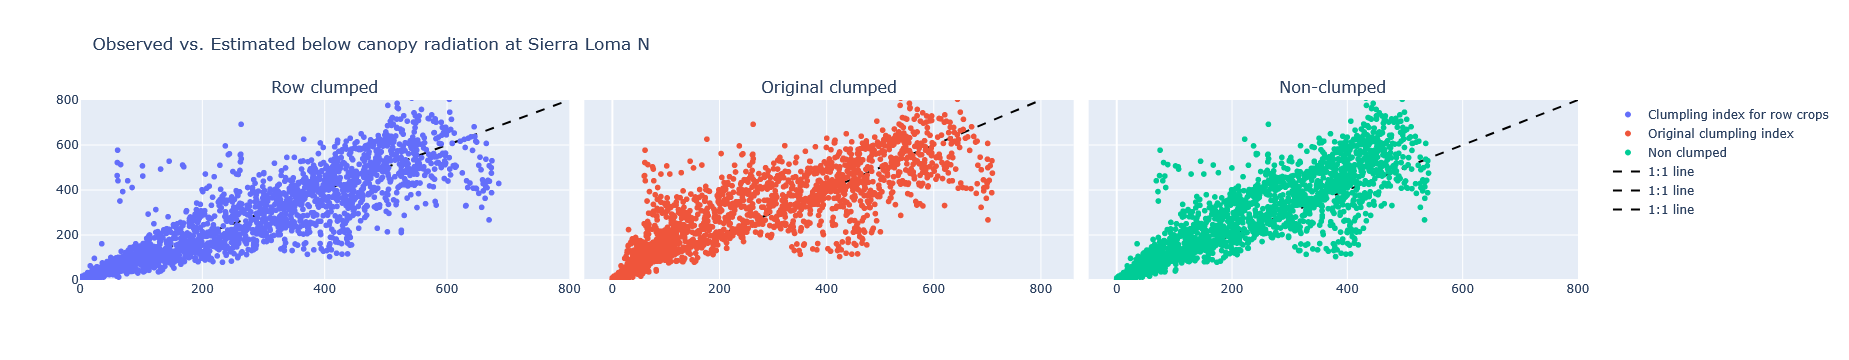

In [15]:
from model_evaluation import double_collocation as dc
from tabulate import tabulate

fig = make_subplots(rows=1, cols=3,
                    shared_yaxes=True,
                    horizontal_spacing=0.01,
                   subplot_titles=["Row clumped", "Original clumped", "Non-clumped"])


fig.add_trace(go.Scattergl(x=sw_below, y=rad["SW_BELOW"], 
                         name="Clumpling index for row crops", mode="markers"),
             row=1, col=1)

fig.add_trace(go.Scattergl(x=sw_below_orig_clumped, y=rad["SW_BELOW"], 
                         name="Original clumpling index", mode="markers"),
             row=1, col=2)

fig.add_trace(go.Scattergl(x=sw_below_orig, y=rad["SW_BELOW"], 
                         name="Non clumped", mode="markers"),
             row=1, col=3)

fig.add_trace(go.Scatter(x=[0, 800], y=[0, 800], mode="lines", name="1:1 line", line={"color": "black", "dash": "dash"}),
             row=1, col=1)
fig.add_trace(go.Scatter(x=[0, 800], y=[0, 800], mode="lines", name="1:1 line", line={"color": "black", "dash": "dash"}),
             row=1, col=2)
fig.add_trace(go.Scatter(x=[0, 800], y=[0, 800], mode="lines", name="1:1 line", line={"color": "black", "dash": "dash"}),
             row=1, col=3)

fig.update_layout(title_text=f"Observed vs. Estimated below canopy radiation at {w_site.label}",
                 hovermode="y", yaxis_range=[0, 800], xaxis_range=[0, 800])


In [16]:
mean_bias, mae, rmse = dc.error_metrics(rad["SW_BELOW"].values, sw_below)
mean_bias_orig_clumped, mae_orig_clumped, rmse_orig_clumped = dc.error_metrics(rad["SW_BELOW"].values, sw_below_orig_clumped)
mean_bias_orig, mae_orig, rmse_orig = dc.error_metrics(rad["SW_BELOW"].values, sw_below_orig)
cor, p_value, slope, intercept, d = dc.agreement_metrics(rad["SW_BELOW"].values, sw_below)
cor_orig_clumped, p_value_orig_clumped, slope_orig_clumped, intercept_orig_clumped, d_orig_clumped = dc.agreement_metrics(rad["SW_BELOW"].values, sw_below_orig_clumped)
cor_orig, p_value_orig, slope_orig, intercept_orig, d_orig = dc.agreement_metrics(rad["SW_BELOW"].values, sw_below_orig)

table = [["bias", mean_bias, mean_bias_orig_clumped,mean_bias_orig],
         ["RMSE", rmse, rmse_orig_clumped, rmse_orig],
         ["MAE",mae, mae_orig_clumped, mae_orig],
         ["Pearson", cor, cor_orig_clumped, cor_orig],
         ["Willmot's d", d, d_orig_clumped, d_orig]]

print(tabulate(table, headers=["Metric", "Row Crop", "Original CI", "Non clumped"]))

Metric         Row Crop    Original CI    Non clumped
-----------  ----------  -------------  -------------
bias          -3.58093       26.336          41.6561
RMSE          89.7787       102.137          99.5755
MAE           59.275         67.5833         65.6207
Pearson        0.893704       0.876324        0.89489
Willmot's d    0.944133       0.931521        0.92085


## Save the results to an ASCII table

In [17]:
# Define the output filename
out_dir = Path().absolute() / "output"
outfile = out_dir / f"FLX_US-{w_site.value}_FLUXNET2015_SW-BELOW_HR.csv"

# Create the output folder in case it does not exist
if not out_dir.exists():
    out_dir.mkdir(parents=True)

# Convert the outputs to a Python dictionary
outdict = {"TIMESTAMP": rad["TIMESTAMP"].dt.strftime("%Y%m%d%H%M"),
           "SW_BELOW_ROWS": sw_below, 
           "SW_BELOW_ORIG-CLUMPED": sw_below_orig_clumped, 
           "SW_BELOW_NON-CLUMPED": sw_below_orig,}

# Crete the output dataframe and save it to csv
pd.DataFrame(outdict).to_csv(outfile, sep=";", na_rep=-9999, index=False)
print(f"Saved to {outfile}")

Saved to C:\Users\06325897T\Nextcloud\1_Projects\ILINK24\Workshop_3SEB_UCDavis\py3SEB-workshop\output\FLX_US-slmN_FLUXNET2015_SW-BELOW_HR.csv


# Conclusions

However several model model limitations can be discussed based on the assumptions made in this approach:

* leaves are small, negligible in size as compared to the canopy size. 
* leaves absorb all incident radiation (i.e. no scattering or transmission) while computing the shadowing for the clumping index.
* Canopy resembles a prism
* [...]

:::{note}
Please feel free comment any thoughts. This is work in progress!!!
:::